# Pipeline without sklearn for Big Basket Food Delivery Service

In [1]:
import pandas as pd
import numpy as np
import itertools
import math
import warnings
warnings.filterwarnings("ignore")

def impute_missing_values(data):
    # Find indices of missing values in the data
    missing_indices = np.where(np.isnan(data))
    
    # Replace missing values with the median of the non-missing values in each column
    for col_idx in range(data.shape[1]):
        col_data = data[:, col_idx]
        non_missing_values = col_data[~np.isnan(col_data)]
        median_value = np.median(non_missing_values)
        col_data[np.isnan(col_data)] = median_value
    
    return data

def label_encode(data):
    unique_values = np.unique(data)
    value_map = {}
    for i, value in enumerate(unique_values):
        value_map[value] = i
    return np.vectorize(value_map.get)(data)


class SimpleImputer:
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        
    def fit(self, X, y=None):
        if self.strategy == 'mean':
            self.fill_value = np.nanmean(X, axis=0)
        elif self.strategy == 'median':
            self.fill_value = np.nanmedian(X, axis=0)
        elif self.strategy == 'most_frequent':
            self.fill_value = np.nanmedian(X, axis=0)
        return self
    
    def transform(self, X):
        X[np.isnan(X)] = self.fill_value
        return X


class LabelEncoder:
    def __init__(self):
        self.labels = {}
        self.rev_labels = {}
        
    def fit(self, X, y=None):
        unique_values = np.unique(X)
        for i, val in enumerate(unique_values):
            self.labels[val] = i
            self.rev_labels[i] = val
        return self
    
    def transform(self, X):
        X_encoded = np.zeros_like(X)
        for val, label in self.labels.items():
            X_encoded[X == val] = label
        return X_encoded
    
    def inverse_transform(self, X_encoded):
        X = np.zeros_like(X_encoded)
        for label, val in self.rev_labels.items():
            X[X_encoded == label] = val
        return X


class Pipeline:
    def __init__(self, steps):
        self.steps = steps
        
    def fit(self, X, y=None):
        for name, estimator in self.steps:
            estimator.fit(X)
        return self
    
    def transform(self, X):
        for name, estimator in self.steps:
            X = estimator.transform(X)
        return X


class ColumnTransformer:
    def __init__(self, transformers):
        self.transformers = transformers
        
    def fit(self, X, y=None):
        for _, transformer, cols in self.transformers:
            transformer.fit(X[cols])
        return self
    
    def transform(self, X):
        X_transformed = np.empty((X.shape[0], 0))
        for name, transformer, cols in self.transformers:
            X_transformed = np.hstack((X_transformed, transformer.transform(X[cols])))
        return X_transformed
    
    
class FunctionTransformer:
    def __init__(self, func):
        self.func = func
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.apply_along_axis(self.func, 1, X)

## Define DecisionTreeRegressor class

In [2]:
class DecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        
    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)
        
    def _build_tree(self, X, y, depth):
        if depth == self.max_depth or len(X) < self.min_samples_split or len(set(y)) == 1:
            return {'leaf': True, 'value': np.mean(y)}
        
        feature, threshold = self._find_best_split(X, y)
        
        if feature is None:
            return {'leaf': True, 'value': np.mean(y)}
        
        left_indices = X[:, feature] < threshold
        right_indices = X[:, feature] >= threshold
        
        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        
        return {'leaf': False, 'feature': feature, 'threshold': threshold, 'left': left_tree, 'right': right_tree}
    
    def _find_best_split(self, X, y):
        best_feature = None
        best_threshold = None
        best_loss = np.inf
        
        for feature in range(X.shape[1]):
            values = X[:, feature]
            thresholds = np.unique(values)
            
            if len(thresholds) > 10:
                thresholds = np.percentile(thresholds, [10, 20, 30, 40, 50, 60, 70, 80, 90])
            
            for threshold in thresholds:
                left_indices = X[:, feature] < threshold
                right_indices = X[:, feature] >= threshold
                
                if len(left_indices) < self.min_samples_leaf or len(right_indices) < self.min_samples_leaf:
                    continue
                
                left_y = y[left_indices]
                right_y = y[right_indices]
                left_weight = len(left_y) / len(y)
                right_weight = len(right_y) / len(y)
                
                loss = left_weight * self.mean_squared_error(left_y) + right_weight * self.mean_squared_error(right_y)
                
                if loss < best_loss:
                    best_feature = feature
                    best_threshold = threshold
                    best_loss = loss
        
        return best_feature, best_threshold
    
    def predict(self, X):
        predictions = []
        for sample in X:
            node = self.tree
            while not node['leaf']:
                if sample[node['feature']] < node['threshold']:
                    node = node['left']
                else:
                    node = node['right']
            predictions.append(node['value'])
        return np.array(predictions)
    
    def mean_squared_error(self, y):
        return np.mean((y - np.mean(y)) ** 2)

## Define RandomForest Regression class

In [3]:
class RandomForestRegressor:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
        
    def fit(self, X, y):
        for i in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            rows = np.random.choice(len(X), size=len(X), replace=True)
            tree.fit(X[rows], y[rows])
            self.trees.append(tree)
            
    def predict(self, X):
        predictions = []
        for tree in self.trees:
            predictions.append(tree.predict(X))
        return np.mean(predictions, axis=0)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        mse = np.mean((y - y_pred) ** 2)
        return 1 - mse / np.var(y)


In [19]:
class GridSearchCV:
    def __init__(self, estimator, param_grid, cv=3):
        self.estimator = estimator
        self.param_grid = param_grid
        self.cv = cv
    
    def fit(self, X_selected, y):
        # Get all combinations of hyperparameters
        param_combinations = self._get_param_combinations(self.param_grid)
        
        # Initialize variables to store results
        best_params = None
        best_score = -np.inf
        
        # Perform cross-validation
        for params in param_combinations:
            scores = []
            for i in range(self.cv):
                # Split data into training and validation sets
                mask = np.ones(len(X_selected), dtype=bool)
                mask[i::self.cv] = False
                X_train, y_train = X_selected[mask], y[mask]
                X_val, y_val = X_selected[~mask], y[~mask]
                
                # Train model and compute score
                model = self.estimator(**params)
                model.fit(X_train, y_train)
                score = model.score(X_val, y_val)
                scores.append(score)
            
            # Compute average score for these hyperparameters
            mean_score = np.mean(scores)
            
            # Update best hyperparameters if necessary
            if mean_score > best_score:
                best_params = params
                best_score = mean_score
        
        # Train model with best hyperparameters on full dataset
        self.best_estimator_ = self.estimator(**best_params)
        self.best_estimator_.fit(X_selected, y)
        
        return self
    
    def predict(self, X_selected):
        return self.best_estimator_.predict(X_selected)
    
    def _get_param_combinations(self, param_grid):
        keys = list(param_grid.keys())
        values = list(param_grid.values())
        param_combinations = []
        for combination in itertools.product(*values):
            params = {keys[i]: combination[i] for i in range(len(keys))}
            param_combinations.append(params)
        return param_combinations

In [5]:
# after defining libraries

In [6]:
# Load data
df = pd.read_csv('Big Basket Food Delivery.csv', encoding='latin-1')
df = df.drop(['Restaurant Name', 'City','Locality','Locality Verbose'], axis=1)


# Impute missing values in the 'Cuisines' column with the mode value
mode_value = df['Cuisines'].mode().values[0]
df['Cuisines'] = df['Cuisines'].fillna(mode_value)

# Replace special characters with NaN
df['Average Cost for two'] = df['Average Cost for two'].replace({'\$': '', ',': ''}, regex=True)
df['Average Cost for two'] = pd.to_numeric(df['Average Cost for two'], errors='coerce')
df['Price range'] = df['Price range'].replace({'\₹': ''}, regex=True)
df['Price range'] = pd.to_numeric(df['Price range'], errors='coerce')

# Impute median value for NaN
df['Average Cost for two'] = impute_missing_values(df['Average Cost for two'].values.reshape(-1, 1)).flatten()
df['Price range'] = impute_missing_values(df['Price range'].values.reshape(-1, 1)).flatten()

# Convert non-numeric columns to numeric using label encoding
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = label_encode(df[col])
        
# Outlier treatment using the IQR method
def outlier_treatment_iqr(column):
    q1, q3 = np.percentile(column, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return np.clip(column, lower_bound, upper_bound)

# Convert non-numeric columns to numeric using label encoding
label_encoder = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = label_encoder.fit_transform(df[col])


## Define the preprocessing steps

In [7]:
# Define the preprocessing steps for categorical and numerical data
categorical_transformer = Pipeline(steps=[
    ('cuisine_imputer', SimpleImputer(strategy='most_frequent')),
    ('label_encoder', LabelEncoder())
])

numerical_transformer = Pipeline(steps=[
    ('avg_cost_imputer' , SimpleImputer(strategy='median')),
    ('price_imputer', SimpleImputer(strategy='median')),
    ('outlier_treatment', FunctionTransformer(func=outlier_treatment_iqr))
])

# Combine the preprocessing steps for categorical and numerical data
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, ['Address', 'Cuisines', 'Has Table booking', 'Has Online delivery', 'Is delivering now','Switch to order menu','Rating color','Rating text']),
    ('num', numerical_transformer, ['Restaurant ID', 'Country Code', 'Longitude','Latitude','Average Cost for two','Price range','Aggregate rating','Votes'])
])


## Visualizing Through Pipeline

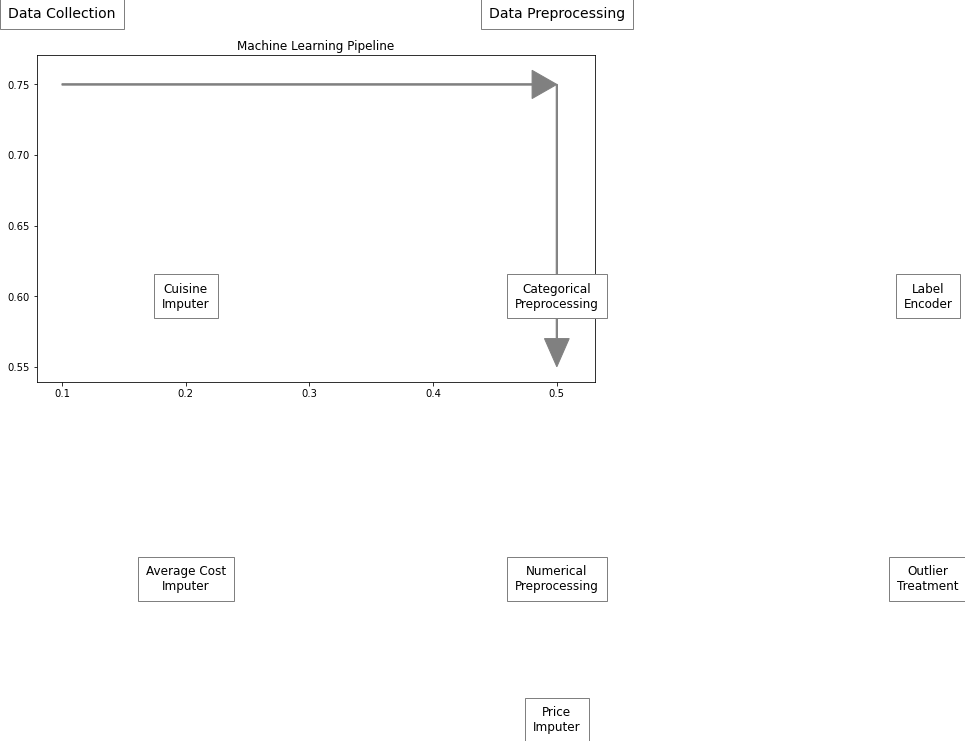

In [39]:
import matplotlib.pyplot as plt

# Define the flowchart elements
data_collection = "Data Collection"
data_preprocessing = "Data Preprocessing"
categorical_preprocessing = "Categorical\nPreprocessing"
numerical_preprocessing = "Numerical\nPreprocessing"
cuisine_imputer = "Cuisine\nImputer"
label_encoder = "Label\nEncoder"
avg_cost_imputer = "Average Cost\nImputer"
price_imputer = "Price\nImputer"
outlier_treatment = "Outlier\nTreatment"
cat_cols = ['Address', 'Cuisines', 'Has Table booking', 'Has Online delivery', 'Is delivering now','Switch to order menu','Rating color','Rating text']
num_cols = ['Restaurant ID', 'Country Code', 'Longitude','Latitude','Average Cost for two','Price range','Aggregate rating','Votes']

# Define the flowchart layout
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Machine Learning Pipeline")

# Define the flowchart elements
ax.text(0.1, 0.8, data_collection, fontsize=14, ha="center", va="center", bbox=dict(facecolor='white', edgecolor='gray', pad=8.0))
ax.text(0.5, 0.8, data_preprocessing, fontsize=14, ha="center", va="center", bbox=dict(facecolor='white', edgecolor='gray', pad=8.0))
ax.text(0.5, 0.6, categorical_preprocessing, fontsize=12, ha="center", va="center", bbox=dict(facecolor='white', edgecolor='gray', pad=8.0))
ax.text(0.5, 0.4, numerical_preprocessing, fontsize=12, ha="center", va="center", bbox=dict(facecolor='white', edgecolor='gray', pad=8.0))
ax.text(0.2, 0.6, cuisine_imputer, fontsize=12, ha="center", va="center", bbox=dict(facecolor='white', edgecolor='gray', pad=8.0))
ax.text(0.8, 0.6, label_encoder, fontsize=12, ha="center", va="center", bbox=dict(facecolor='white', edgecolor='gray', pad=8.0))
ax.text(0.2, 0.4, avg_cost_imputer, fontsize=12, ha="center", va="center", bbox=dict(facecolor='white', edgecolor='gray', pad=8.0))
ax.text(0.5, 0.3, price_imputer, fontsize=12, ha="center", va="center", bbox=dict(facecolor='white', edgecolor='gray', pad=8.0))
ax.text(0.8, 0.4, outlier_treatment, fontsize=12, ha="center", va="center", bbox=dict(facecolor='white', edgecolor='gray', pad=8.0))

# Define the flowchart arrows
ax.arrow(0.1, 0.75, 0.4, 0, length_includes_head=True, head_width=0.02, head_length=0.02, fc='gray', ec='gray')
ax.arrow(0.5, 0.75, 0, -0.2, length_includes_head=True, head_width=0.02, head_length=0.02, fc='gray', ec='gray')


## Model building Through pipeline

In [8]:
X = df.drop('Aggregate rating', axis=1).values
y = df['Aggregate rating'].values
n_train = math.floor(0.8 * X.shape[0])
n_test = math.ceil((1-0.8) * X.shape[0])
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

In [9]:
# Define the random forest regressor
rf = RandomForestRegressor(n_estimators=100)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', rf)
])

In [10]:
# Fit the pipeline on the training data
rf.fit(X_train, y_train)


In [11]:
# Use the pipeline to make predictions on the test data
y_pred = rf.predict(X_test)

In [17]:
# Calculate the mean of y_test
y_mean = np.mean(y_test)

# Calculate the sum of squared residuals and total sum of squares
SS_res = sum((y_test - y_pred) ** 2)
SS_tot = sum((y_test - y_mean) ** 2)

# Calculate the R2 score
r2 = 1 - (SS_res / SS_tot)

print('R2 score for perfect model is', r2)


R2 score for perfect model is 0.989014908365663


In [20]:
param_grid = {'max_depth': [100, 200, 300, 400], 'min_samples_split': [20, 30, 40, 50]}

#from sklearn.tree import RandomForestRegressor

estimator = RandomForestRegressor
cv = 3

grid_search = GridSearchCV(estimator, param_grid, cv=cv)


grid_search.fit(X_train,y_train)
y_pred=grid_search.predict(X_test)
best_estimator = grid_search.best_estimator_

In [46]:
def r2_score(y_test, y_pred):
    mean_y_test = sum(y_test) / len(y_test)
    sst = sum([(y - mean_y_test)**2 for y in y_test])
    ssr = sum([(y - yp)**2 for y, yp in zip(y_test, y_pred)])
    r2 = 1 - (ssr / sst)
    return r2

In [47]:
# Define pipeline
def pipeline(X_train, y_train):
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    r2_score= r2_score(y_test, y_pred)
    return r2_score



In [48]:
# Run pipeline on dataset using decision tree
grid = GridSearchCV(estimator, param_grid, cv=cv)


In [49]:
print("Best hyperparameters:", best_estimator)
print("Validation R2 score:", r2)

Best hyperparameters: RandomForestRegressor(max_depth=200, min_samples_split=50)
Validation R2 score: 0.9088284796091817
